Makes a bar plot of time series landcover data. Can work from saved Excel file with all stats or recompute values each time. Be sure to comment out appropriate.
Notes
* Make sure using inner/common ROIs

TODO: 
*


In [1]:
## imports
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from python_env import *
# from memory_profiler import profile

In [2]:
## User vars
# min_size=500 # meters squared
# regions=np.array(['Daring','Baker','PAD','YFLATS']) # See env.py

## constants
colors_lookup={'early 2017':'#B7B7A4', 'late 2017':'#FFD1AD', 'late 2018':'#D0A68A', 'late 2019':'#B97550'} #v2
colors_lookup_category = {'water':'#BED2FF', 'wet emergent':'#58D918', 'wet emergent nl': '#B4E39D'}
labels=dict(zip(
    [
    'daring_21405_17063_010_170614_L090_CX_01_LUT-Freeman_rcls_brn.tif',
    'daring_21405_17094_010_170909_L090_CX_01_LUT-Freeman_rcls_brn.tif',
    'bakerc_16008_18047_005_180821_L090_CX_02_Freeman-inc_rcls_brn.tif',
    'bakerc_16008_19059_012_190904_L090_CX_01_Freeman-inc_rcls_brn.tif',
    'PAD_170613_mosaic_rcls_brn.tif',
    'PAD_170908_mosaic_rcls_brn.tif',
    'PAD_180821_mosaic_rcls_brn.tif',
    'padelE_36000_19059_003_190904_L090_CX_01_Freeman-inc_rcls_brn.tif',
    'YFLATS_170621_mosaic_rcls_brn.tif',
    'YFLATS_170916_mosaic_rcls_brn.tif',
    'YFLATS_180827_mosaic_rcls_brn.tif',
    'YFLATS_190914_mosaic_rcls_brn.tif'
    ],

    [
    ['Daring June 2017', 'early 2017'],
    ['Daring Sept 2017', 'late 2017'],
    ['Baker Aug 2018', 'late 2018'],
    ['Baker Sept 2019', 'late 2019'],
    ['PAD June 2017', 'early 2017'],
    ['PAD Sept 2017', 'late 2017'],
    ['PAD Aug 2018', 'late 2018'],
    ['PAD Sept 2019', 'late 2019'],
    ['YFLATS June 2017', 'early 2017'],
    ['YFLATS Sept 2017', 'late 2017'],
    ['YFLATS Aug 2018', 'late 2018'],
    ['YFLATS Sept 2019', 'late 2019']
    ]
))
best_dates=[
    'YFLATS_180827_mosaic_rcls_brn.tif', 'padelE_36000_19059_003_190904_L090_CX_01_Freeman-inc_rcls_brn.tif', 'daring_21405_17094_010_170909_L090_CX_01_LUT-Freeman_rcls_brn.tif', 'bakerc_16008_18047_005_180821_L090_CX_02_Freeman-inc_rcls_brn.tif'
            ]

## Plotting style
plt.style.use('/mnt/d/Dropbox/Python/Matplotlib-rcParams/presentation.mplstyle')

In [3]:
## I/O
files_in=glob.glob(os.path.join(output_raster_dir_common_roi, '*.tif')) #common-roi

In [5]:
## load data (skip if loading summary from excel)
''' Possible landcover vals (as of June 14, 2021): 2,3,4,5, 42,43,44,45,52, 25, 35
'''

list_to_concat = []
for i, filepath in enumerate(files_in):
    print(f'\t(File {i+1} of {len(files_in)})\n')
    filename=os.path.basename(filepath)
    df = pd.DataFrame({'filename':filename, 'site_ssn_yr':labels[filename][0],
                       'season':labels[filename][1].split(' ')[0], 'site_ssn':labels[filename][1],
                        'site':labels[filename][0].split(' ')[0], 'year':labels[filename][1].split(' ')[1]}, 
                         index=[i])
    with rio.open(filepath) as src:
        lc = src.read(1)
        src_crs=src.crs
        src_res=src.res
        src_shp=src.shape
#         src=src
#         print(src.profile)
#         profile = src.profile.copy() # save for output raster
    df['area_tot_in_roi_km2'] = np.sum(np.isin(lc, [non_roi_val, NODATAVALUE], invert=True)) * np.prod(src_res) / 1e6# np.sum(np.isin(lc, [1,2,3,4,5])) * np.prod(src_res) / 1e6
#     df['area_valid_in_roi_km2'] = np.sum(np.isin(lc, [non_roi_val, NODATAVALUE, ], invert=True)) * np.prod(src_res) / 1e6
    df['area_land'] = np.sum(np.isin(lc, classes_reclass['dry_land'])) * np.prod(src_res) / 1e6
    df['area_wet'] = np.sum(np.isin(lc, classes_reclass['wet'])) * np.prod(src_res) / 1e6
    df['area_wet_emerg'] = np.sum(np.isin(lc, classes_reclass['wet_emergent'])) * np.prod(src_res) / 1e6
    df['area_water'] = np.sum(np.isin(lc, classes_reclass['water'])) * np.prod(src_res) / 1e6
    df['area_wet_graminoid'] = np.sum(np.isin(lc, classes_reclass['wet_graminoid'])) * np.prod(src_res) / 1e6
    df['area_wet_shrubs'] = np.sum(np.isin(lc, classes_reclass['wet_shrubs'])) * np.prod(src_res) / 1e6
    df['area_wet_forest'] = np.sum(np.isin(lc, classes_reclass['wet_forest'])) * np.prod(src_res) / 1e6
    df['area_wet_emerg_no_lk'] = np.sum(np.isin(lc, classes_reclass['wet_emergent_no_lake'])) * np.prod(src_res) / 1e6
    df['area_bridge'] = np.sum(np.isin(lc, bridge_val)) * np.prod(src_res) / 1e6
    df['area_water_no_lk'] = np.sum(np.isin(lc, classes_reclass['water_no_lake'])) * np.prod(src_res) / 1e6
    df['area_non_roi'] = np.sum(np.isin(lc, non_roi_val)) * np.prod(src_res) / 1e6
    df['no_data'] = np.sum(np.isin(lc, NODATAVALUE)) * np.prod(src_res) / 1e6
    df['area_per_pixel_m2'] = np.prod(src_res)
    
    # Smart way:
#     for key in classes_reclass.keys():
#         df[key] = np.sum(np.isin(lc, classes_reclass[key])) * np.prod(src_res) / 1e6
    
    ## append to list
    list_to_concat.append(df)

## Merge dataframes into one
df_all = pd.concat(list_to_concat)

## view
df_all

	(File 1 of 12)

	(File 2 of 12)

	(File 3 of 12)

	(File 4 of 12)

	(File 5 of 12)

	(File 6 of 12)

	(File 7 of 12)

	(File 8 of 12)

	(File 9 of 12)

	(File 10 of 12)

	(File 11 of 12)

	(File 12 of 12)



,filename,site_ssn_yr,season,site_ssn,site,year,area_tot_in_roi_km2,area_land,area_wet,area_wet_emerg,...,wet_graminoid,wet_shrubs,wet_forest,water_no_lake,wet_graminoid_no_lake,wet_shrubs_no_lake,wet_forest_no_lake,wet_emergent_no_lake,wet_non_lake,water_not_valid
0,bakerc_16008_18047_005_180821_L090_CX_02_Freem...,Baker Aug 2018,late,late 2018,Baker,2018,1159.437094,814.133016,312.904208,32.094875,...,24.379976,7.598895,0.116004,0.005802,1.244075,21.864996,0.015854,23.124925,23.130727,0.0
1,bakerc_16008_19059_012_190904_L090_CX_01_Freem...,Baker Sept 2019,late,late 2019,Baker,2019,1164.787613,839.265884,312.355488,21.305035,...,18.900698,2.285899,0.118438,0.024752,1.009642,2.851158,0.015516,3.876316,3.901068,0.0
2,daring_21405_17063_010_170614_L090_CX_01_LUT-F...,Daring June 2017,early,early 2017,Daring,2017,3036.761095,2220.518252,810.286175,12.875405,...,12.347346,0.526952,0.001108,0.259789,1.400335,0.305689,0.000069,1.706094,1.965883,0.0
3,daring_21405_17094_010_170909_L090_CX_01_LUT-F...,Daring Sept 2017,late,late 2017,Daring,2017,3036.742258,2256.180280,774.971083,11.434582,...,11.205848,0.225307,0.003427,0.270271,1.249521,0.078333,0.000104,1.327958,1.598229,0.0
4,padelE_36000_19059_003_190904_L090_CX_01_Freem...,PAD Sept 2019,late,late 2019,PAD,2019,1346.663091,956.955819,241.087120,97.427616,...,57.274524,39.976801,0.176291,0.017298,10.655182,20.038187,0.026164,30.719533,30.736831,0.0
5,PAD_170613_mosaic_rcls_brn.tif,PAD June 2017,early,early 2017,PAD,2017,1556.912496,965.769490,438.460364,233.689713,...,153.686801,78.338626,1.664286,0.046378,21.654513,13.017382,0.080738,34.752633,34.799011,0.0
6,PAD_170908_mosaic_rcls_brn.tif,PAD Sept 2017,late,late 2017,PAD,2017,1556.912395,1055.847746,345.899492,138.805040,...,121.508068,17.135891,0.161081,0.101385,30.961577,6.206477,0.012806,37.180860,37.282245,0.0
7,PAD_180821_mosaic_rcls_brn.tif,PAD Aug 2018,late,late 2018,PAD,2018,1556.913377,1066.131411,327.993283,171.758971,...,101.954475,68.615686,1.188809,0.034518,13.054165,31.778599,0.040586,44.873350,44.907868,0.0
8,YFLATS_170621_mosaic_rcls_brn.tif,YFLATS June 2017,early,early 2017,YFLATS,2017,4816.698441,3913.107517,404.893452,107.860232,...,86.137970,17.843395,3.878867,0.088998,47.840615,43.426513,1.739140,93.006268,93.095266,0.0
9,YFLATS_170916_mosaic_rcls_brn.tif,YFLATS Sept 2017,late,late 2017,YFLATS,2017,5114.488329,4191.437506,419.325485,96.204302,...,68.986669,23.102661,4.114973,0.116681,39.201312,57.531847,1.259914,97.993073,98.109755,0.0


In [23]:
## temp vis
%matplotlib widget
plt.imshow(lc)
# plt.imshow(lc==1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [6]:
## Save or load dataframe as excel file
os.makedirs(os.path.join(output_raster_dir_common_roi, 'combined_excel'), exist_ok=True)
excel_pth = os.path.join(output_raster_dir_common_roi, 'combined_excel', 'landcover_stats.xlsx')

## SAVE
# df_all.to_excel(excel_pth)
# print(f'Saved as excel: {excel_pth}')

## LOAD
df_all=pd.read_excel(excel_pth)
print(f'Loaded from excel: {excel_pth}')

Saved as excel: /mnt/f/PAD2019/classification_training/PixelClassifier/Final-ORNL-DAAC/landcover_raster_burned/combined_excel/landcover_stats.xlsx


In [8]:
## Helper function, bc my matplotlib is out of date...
# Modified from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
def autolabel(rects, text, offset, fontsize=None, rotation=None):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate(text,
                    xy=(rect.get_x() + rect.get_width() / 2, height + offset),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=fontsize, rotation=rotation)

event: YFLATS June 2017; num bars: 4, left bar: -0.3
event: PAD June 2017; num bars: 4, left bar: 0.7
event: Daring June 2017; num bars: 2, left bar: 1.8499999999999999
event: Baker Aug 2018; num bars: 2, left bar: 2.85


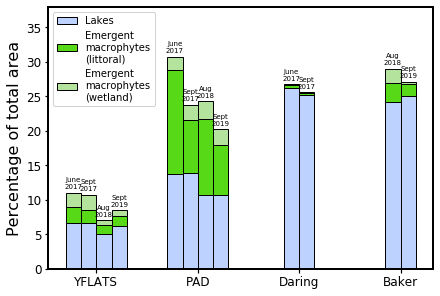

In [12]:
## Plot v4
%matplotlib inline

x = np.arange(len(regions))  # the label locations
# x=np.arange(12) 
width = 0.6 #0.70  # the width of the bars

for i, region in enumerate(regions):
    events = df_all.query(f'site == "{region}"').sort_values(['year', 'site_ssn']).site_ssn_yr # hack based on year and alphanumerical to get date sorting
    for j, event in enumerate(events):
        df_filter_tmp = df_all.query(f'(site == "{region}") and (site_ssn_yr == "{event}") ')
        heights_water = df_filter_tmp.area_water / df_filter_tmp.area_tot_in_roi_km2 * 100
        heights_we = df_filter_tmp.area_wet_emerg / df_filter_tmp.area_tot_in_roi_km2 * 100
        heights_we_nl = (df_filter_tmp.area_wet_emerg_no_lk + df_filter_tmp.area_water_no_lk) / df_filter_tmp.area_tot_in_roi_km2 * 100
        num_bars = len(events)
#         width_tmp=width/len(heights_water)
        x_bar=x[i]-width/(num_bars/2) + width*0.375*(4-num_bars) + width/4*j
        x_bar=x[i]-width/2 + width*0.125*(4-num_bars) + width/4*j
        if j == 0:
            print(f'event: {event}; num bars: {num_bars}, left bar: {x_bar}')
        w = plt.bar(x_bar, heights_water,
                    width/4, label = 'Water', color=colors_lookup_category['water'], 
                    align='edge', edgecolor='black') # x-width/2, # color = 
        em = plt.bar(x_bar, heights_we,  
                    width/4, bottom=heights_water.to_numpy(), label = 'Emergent macrophytes (littoral)', 
                    align='edge', color=colors_lookup_category['wet emergent'], edgecolor='black')
        emnl = plt.bar(x_bar, heights_we_nl,  
                    width/4, bottom=heights_water.to_numpy()+heights_we.to_numpy(), label = 'Emergent macrophytes (wetland)', 
                    align='edge', color=colors_lookup_category['wet emergent nl'], edgecolor='black')# em no lake
        autolabel(emnl, event.split(' ')[1] + '\n' + event.split(' ')[2], heights_water + heights_we, fontsize=7)
plt.ylim([0,38])
plt.xticks(x, regions)
plt.ylabel('Percentage of total area')
plt.legend(['Lakes', 'Emergent\nmacrophytes\n(littoral)', 'Emergent\nmacrophytes\n(wetland)'], fontsize='10')

## save fig
figname=os.path.join(fig_dir, 'Bar-landcover-temporal')
plt.savefig(figname + '.jpg', dpi=300)
plt.savefig(figname + '.pdf', dpi=300)

# Scrap

site
Baker     AxesSubplot(0.125,0.125;0.775x0.755)
Daring    AxesSubplot(0.125,0.125;0.775x0.755)
PAD       AxesSubplot(0.125,0.125;0.775x0.755)
YFLATS    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

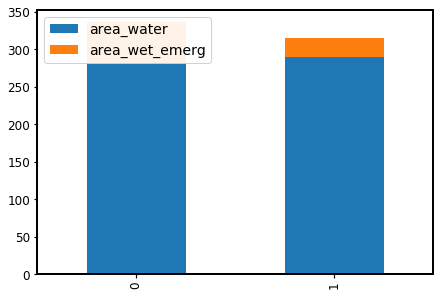

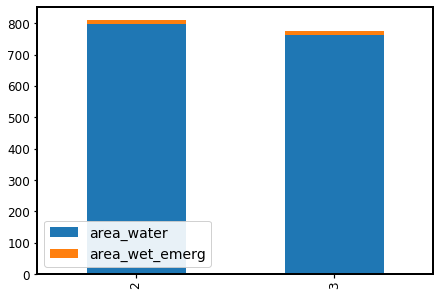

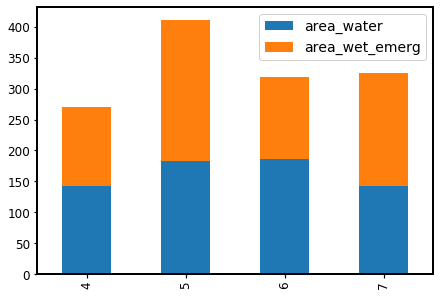

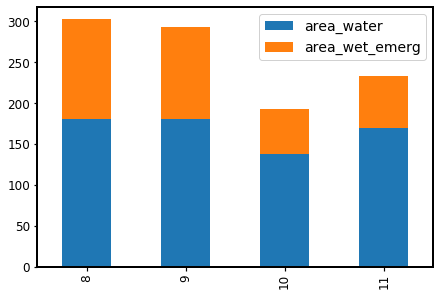

In [106]:
## Plot!
%matplotlib inline
# df_all.plot.bar()
# df_all.groupby(['site', 'year']).plot.bar()
df_all.loc[:, ['area_water','area_wet_emerg', 'site']].groupby('site').plot.bar(stacked=True)

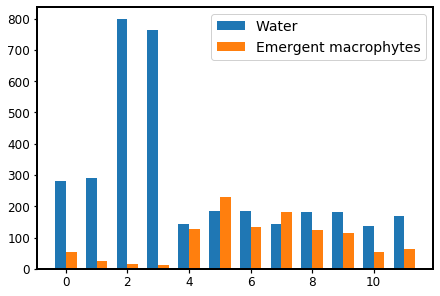

In [113]:
## Plot v2
%matplotlib inline

x = np.arange(len(regions))  # the label locations
x=np.arange(12) 
width = 0.35  # the width of the bars
plt.bar(x-width/2, df_all.area_water, width, label = 'Water') # x-width/2, 
plt.bar(x+width/2, df_all.area_wet_emerg, width, label = 'Emergent macrophytes')
plt.legend()


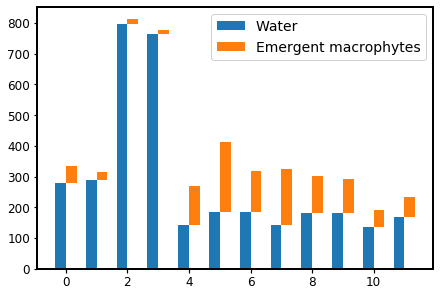

In [115]:
## Plot v3
%matplotlib inline

x = np.arange(len(regions))  # the label locations
x=np.arange(12) 
width = 0.35  # the width of the bars
plt.bar(x-width/2, df_all.area_water, width, label = 'Water') # x-width/2, 
plt.bar(x+width/2, df_all.area_wet_emerg,  width, bottom=df_all.area_water, label = 'Emergent macrophytes')
# plt.set_xticklabels()
plt.legend()
